![](Zillow.jpg)

# Clustering Demo
Using the Zillow Dataset found on Kaggle, we are attempting to predicting Logerror of Zestimates

This walkthrough will focus on the clustering aspect of machine learning, acquisition and preparation are already complete.

<hr style="border:2px solid gray">


### Imports

In [1]:
import acquire
import prepare
import explore

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score


import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

## Acquire & Prepare

Acquisition and Preparation steps have already been completed for purposes of this demonstration.

In preparation (all captured in prepare.py):
- corrected column names
- changed datatypes
- imputed values 
- drop nulls 
- looked at outliers
- creates new column with county name


________

In [15]:
#cleaned data
zillow = prepare.final_prep_zillow(zillow)

In [16]:
#take a look
zillow.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,county,property_age
0,14297519,0.025595,3.5,4,3100,6059,33634931,-117869207,4506,96978,1998,485713,1023282,537569,11013,20170101,orange,19
1,17052889,0.055619,1.0,2,1465,6111,34449266,-119281531,12647,97099,1967,88000,464000,376000,5672,20170101,ventura,50
2,14186244,0.005383,2.0,3,1243,6059,33886168,-117823170,8432,97078,1962,85289,564778,479489,6488,20170101,orange,55
3,12177905,-0.103410,3.0,4,2376,6037,34245180,-118240722,13038,96330,1970,108918,145143,36225,1777,20170101,los_angeles,47
4,12095076,-0.001011,3.0,4,2962,6037,34145202,-118179824,63000,96293,1950,276684,773303,496619,9516,20170101,los_angeles,67


In [19]:
#how much data are we working with
zillow.shape

(48646, 18)

<hr style="border:2px solid black"> </hr>

### Split data

In [25]:
#use split function in prepare.py
train, validate, test = prepare.simple_split(zillow)

train -> (27241, 17)
validate -> (11675, 17)
test -> (9730, 17)


In [26]:
#isolate target
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.zillow_split(zillow, 'logerror')

<hr style="border:2px solid black"> </hr>

In [ ]:
def create_cluster(df, X, k):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 123)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df['cluster'] = kmeans.predict(X_scaled)
    df['cluster'] = 'cluster_' + df.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids

## Clustering

### Brainstorm about clusters:
- **WHAT** is logerror??
    - predicted sale value being different from actual sale value


- Clusters have been found between:
    - age of property and number of bedrooms
    - age of property and total square feet of the property
    - longitude and total square feet of the property

### Cluster #1

In [51]:
#chose variables for this possible cluster
X = train[['longitude', 'total_sqft']]
#tke a look
X.head()

,longitude,total_sqft
4117,-118101120,1384
28813,-118127946,1215
29847,-118471283,2511
47242,-119289721,1040
29768,-118296847,2520


In [52]:
# Scale the X
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

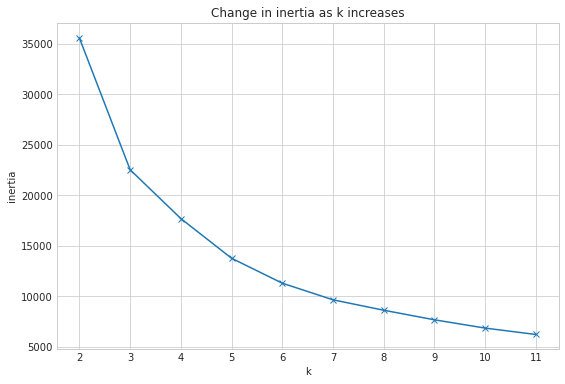

In [53]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

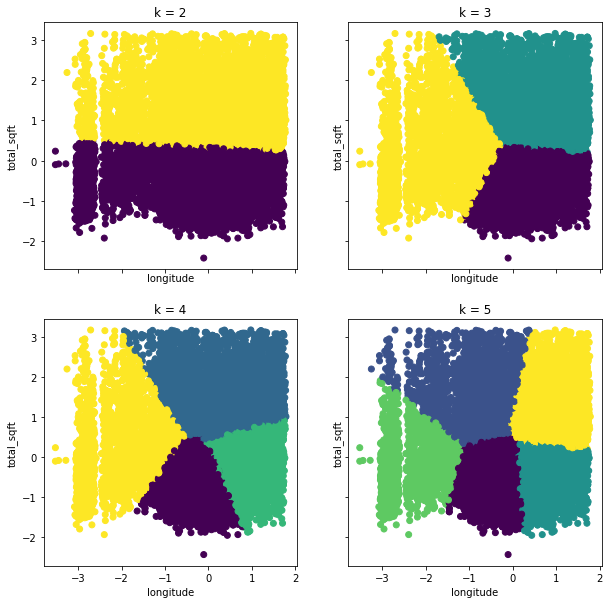

In [54]:
#use scatter_plot function from explore.py
#this will show you different clusters with varying k values
explore.scatter_plots(X_scaled, col_name= 'longitude', col_name_two= 'total_sqft')

In [55]:
#use create_cluster function from explore.py
train, X_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X, 5, col_name= 'cluster_longitude_totalsqft')

In [56]:
#take a look at the new column
train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft
4117,11296376,0.001174,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28,0
28813,12476553,0.091318,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65,0
29847,11125066,-0.010416,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4,1
47242,17073351,-0.040713,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54,2
29768,12249440,0.050421,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91,1


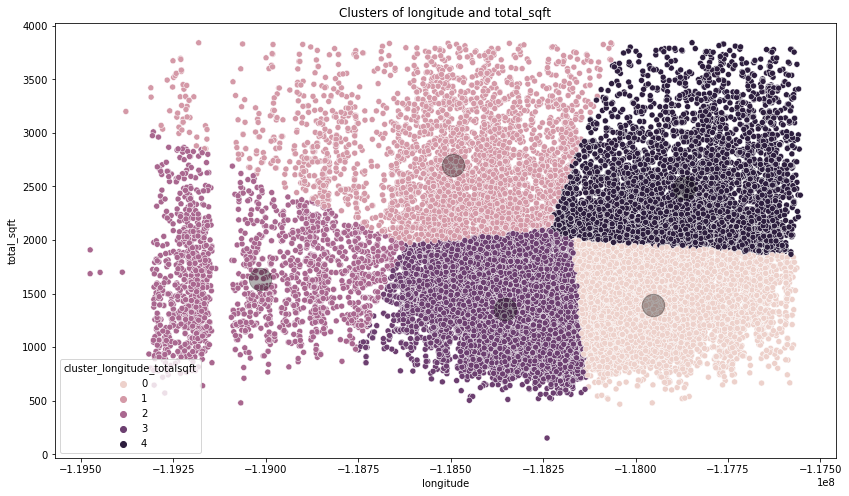

In [57]:
#plot only k=5
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'longitude', y = 'total_sqft', data = train, hue = 'cluster_longitude_totalsqft')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
centroids.plot.scatter(y='total_sqft', x= 'longitude', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of longitude and total_sqft')
plt.show()

### Cluster #1 Takeaways:

- inertia seems to be flattening out around k=5

- **cluster_0**: longitude between -1.18 to -1.175 and sqft of ~500 to ~2000  

- **cluster_1**: longitude between -1.194 to -1.18 and sqft of ~2000 to ~3800  

- **cluster_2**: longitude between -1.1950 to -1.186 and sqft of ~500 to ~3000 (least grouped together in my opinion)

- **cluster_3**: longitude between -1.1875 to -1.1826 and sqft of ~100 to ~2000 (smallest properties) 

- **cluster_4**: longitude between -1.1825 to -1.1750 and sqft of ~2000 to ~3800  

____________________

## Cluster #2

In [58]:
#chose variables for this possible cluster
X2 = train[['property_age', 'total_sqft']]
#take a look
X2.head()

,property_age,total_sqft
4117,28,1384
28813,65,1215
29847,4,2511
47242,54,1040
29768,91,2520


In [59]:
# Scale the X
scaler = StandardScaler().fit(X2)
X2_scaled = pd.DataFrame(scaler.transform(X2), columns= X2.columns).set_index([X2.index.values])

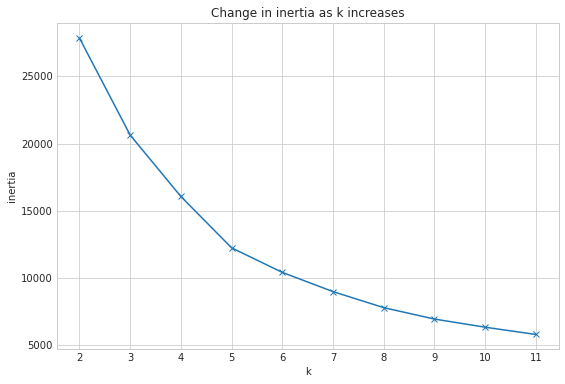

In [60]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

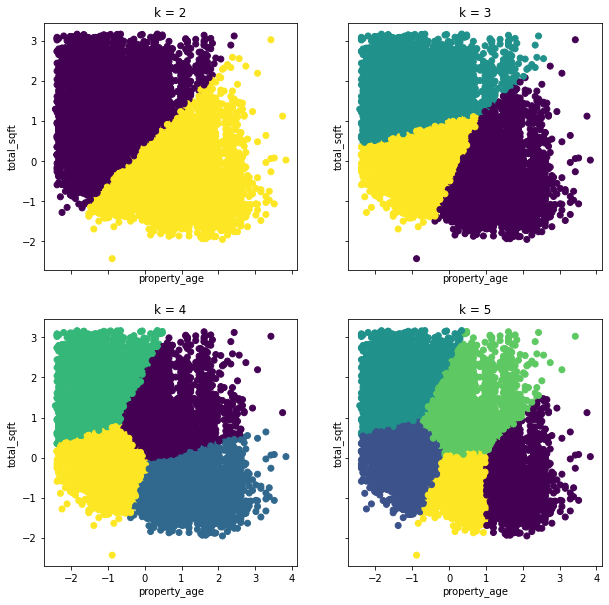

In [61]:
#use scatter_plots function from explore.py
#this will show you different clusters with varying k values
explore.scatter_plots(X2_scaled, col_name= 'property_age', col_name_two= 'total_sqft')

In [62]:
#use create_cluster function from explore.py
train, X2_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X2, 3, col_name= 'cluster_age_totalsqft')

In [63]:
#take a look at the new column
train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft,cluster_age_totalsqft
4117,11296376,0.001174,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28,0,2
28813,12476553,0.091318,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65,0,1
29847,11125066,-0.010416,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4,1,0
47242,17073351,-0.040713,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54,2,1
29768,12249440,0.050421,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91,1,1


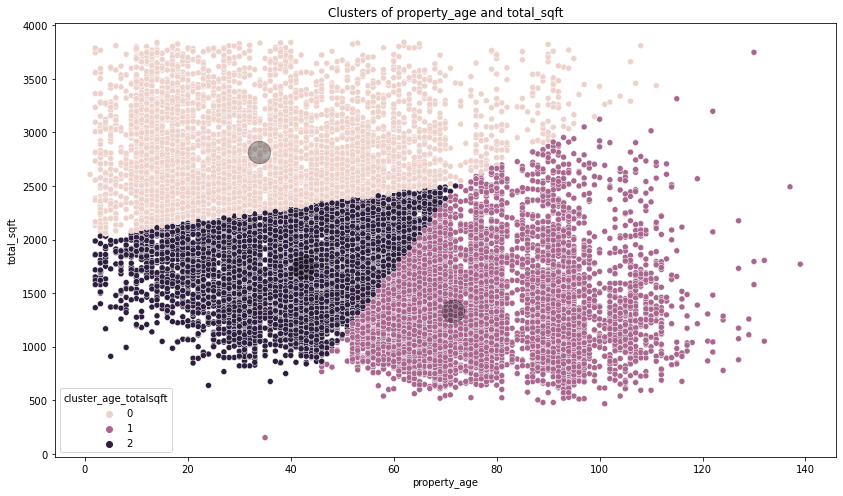

In [64]:
#plot only k=3
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'property_age', y = 'total_sqft', data = train, hue = 'cluster_age_totalsqft')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X2_scaled.columns)
centroids.plot.scatter(y='total_sqft', x= 'property_age', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of property_age and total_sqft')
plt.show()

### Cluster #2 Takeaways:

- **cluster_0**: The Largest Sqft 
    - most vast range for age of property (between 0 to ~120 years old)
    - Sqft of property all above 2000 sqft. Largest properties

<br>

- **cluster_1**: Older & Smaller
    - age of property between ~50 to ~120 years old (with some outliers). Oldest homes
    - Sqft of ~500 to ~2500 (with some outliers)  

<br>

- **cluster_2**: Smallest & newest
    - age of property between 0 year to 70 years. 
    - Sqft of ~500 to ~2250. 


______________________

## Cluster #3

In [65]:
#chose variables for this possible cluster
X3 = train[['bedrooms', 'property_age']]
#tke a look
X3.head()

,bedrooms,property_age
4117,3,28
28813,3,65
29847,4,4
47242,3,54
29768,5,91


In [66]:
# Scale the X
scaler = StandardScaler().fit(X3)
X3_scaled = pd.DataFrame(scaler.transform(X3), columns= X3.columns).set_index([X3.index.values])

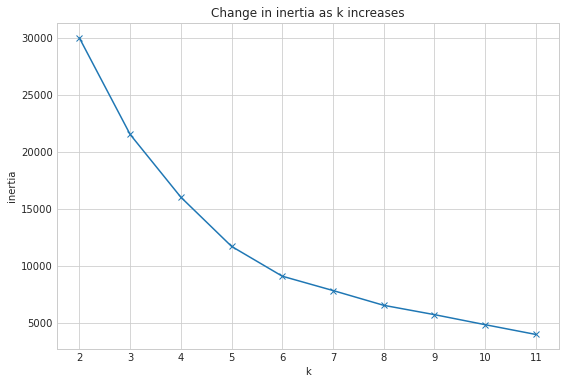

In [67]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

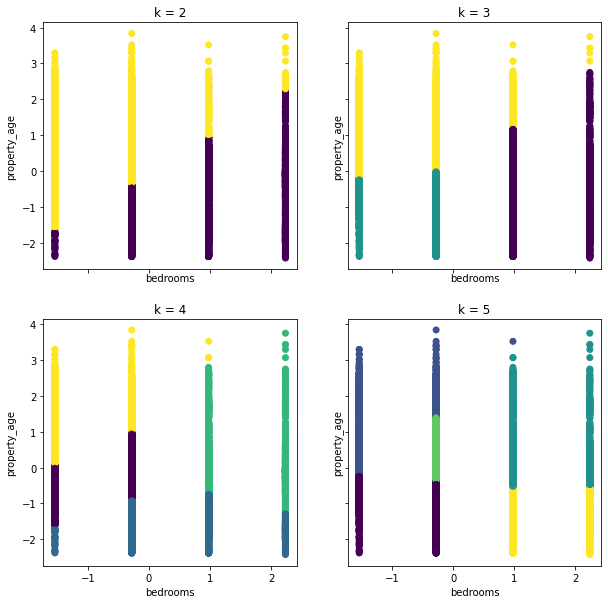

In [68]:
#use scatter_plots function from explore.py
#this will show you different clusters with varying k values
explore.scatter_plots(X3_scaled, col_name= 'bedrooms', col_name_two= 'property_age')

In [69]:
#use create_cluster function from explore.py
train, X3_scaled, scaler, kmeans, centroids_scaled = explore.create_cluster(train, X3, 4, col_name= 'cluster_age_bedrooms')

In [70]:
#take a look at the new column
train.head()

,parcelid,logerror,bathrooms,bedrooms,total_sqft,county_code,latitude,longitude,lotsizesquarefeet,regionidzip,year_built,structuretaxvaluedollarcnt,value_assessed,landtaxvaluedollarcnt,tax_amount,transactiondate,property_age,cluster_longitude_totalsqft,cluster_age_totalsqft,cluster_age_bedrooms
4117,11296376,0.001174,2.0,3,1384,6037,34703526,-118101120,5803,97318,1989,71286,92216,20930,1962,20170127,28,0,2,2
28813,12476553,0.091318,2.0,3,1215,6037,33869841,-118127946,6570,96208,1952,99505,185287,85782,2437,20170601,65,0,1,1
29847,11125066,-0.010416,3.0,4,2511,6037,34447711,-118471283,9195,96373,2013,342761,549867,207106,7157,20170606,4,1,0,2
47242,17073351,-0.040713,1.5,3,1040,6111,34309700,-119289721,8395,97081,1963,38452,51864,13412,596,20170823,54,2,1,1
29768,12249440,0.050421,4.0,5,2520,6037,33884382,-118296847,6759,96104,1926,197342,388191,190849,4828,20170606,91,1,1,0


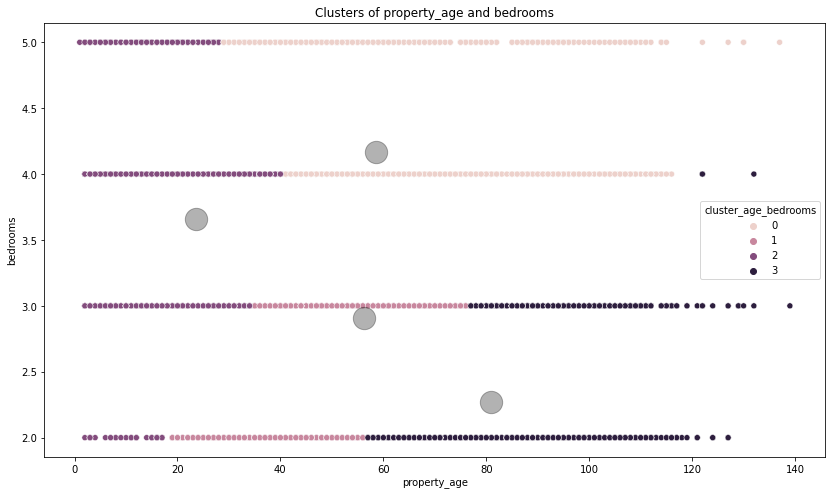

In [71]:
#plot only k=4
plt.figure(figsize=(14, 8))
sns.scatterplot(x = 'property_age', y = 'bedrooms', data = train, hue = 'cluster_age_bedrooms')
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X3_scaled.columns)
centroids.plot.scatter(y='bedrooms', x= 'property_age', ax=plt.gca(), alpha=.30, s=500, c='black')
plt.title('Clusters of property_age and bedrooms')
plt.show()

### Cluster #3 Takeaways:

- **cluster_0**: The biggies
    - all have 4 or 5 bedrooms
    - 25 years old to 140 years old

<br>

- **cluster_1**: Middle of the road
    - all have 2 or 3 bedrooms
    - 20 years old to 80 years old 

<br>

- **cluster_2**: The youngsters
    - have largest range of bedrooms (2-5)
    - 0 years old to 40 years old
    
<br>

- **cluster_3**: The Oldies
    - have 2 or 3 bedrooms (except 2)
    - ~58 years old to 140 years old

<hr style="border:2px solid black"> </hr>

# Next Steps:
As we discussed in the lecture, we can now use these clusters to:
- continue to explore our segments
- as features in a further ML model (regression) to help predict the logerror